In [2]:
import numpy as np
from laminar_tools.csd.csd import csd1d
from laminar_tools.lfp.lfp import coherence_matrix, welch_relative_power
from laminar_tools.lfp.lfpplot import laminar_plot

Load practice data.

lfp signal is one linear column of electrodes from 64D UCLA probe with 50 micron contact spacing recorded from ferret auditory cortex. Signal is 4th order butterworth bandpass filtered between 1-150Hz and downsampled to 500Hz. Timestamps (sample number) correspond to broadband noise burst stimuli centered around best response frequency tuning of spikes. Channels are sorted from electrode tip upwards.

In [9]:
# assume data is in current directory. Should happen by default in a notebook.
lfp = np.load('practice_lfp.npy')
timestamps = np.load('practice_timestamps.npy')

laminar identification tools include a simple one-dimensional CSD estimation and two raw lfp based methods - relative power per frequency as a function of depth and channel by channel coherence of the "gamma range" lfp.

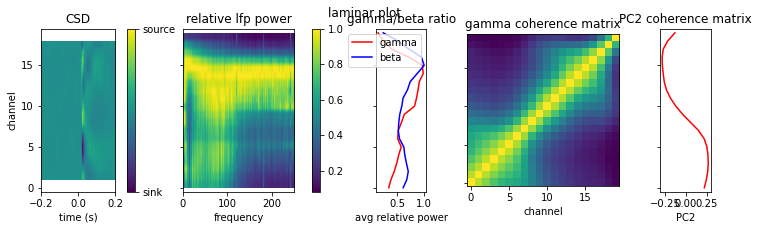

In [12]:
### CSD ###

# average over stimuli to get event related potential
fs = 500
window = 0.2*fs
channels, time = lfp.shape
lfp_events = np.zeros((len(timestamps), channels, int(2*window)))
for i in range(len(timestamps)):
    lfp_events[i, :, :] = lfp[:, int(timestamps[i] - window):int(timestamps[i] + window)]
erp = lfp_events.mean(axis=0)

# Calculate 1D CSD
# number of channels to apply hamming window filter over - odd integer - ~300-500 microns of spatial filtering seems reasonable given literature - neuropixel CSD looks okay with 25 contact filtering
spatial_filter_channel_num = 7
csd = csd1d(erp, spatial_filter_channel_num)

### RELATIVE POWER ###

# number of samples used to calculate power spectrum for each segment - should be enough samples to estimate power at lower frequency range <4Hz. ~2 seconds is more than enough (1024 samples for 500Hz sampling rate). Frequency list is output to allow slicing should you want to focus on particular range of frequencies. power and relative power are in channel by frequency bin matrix.

freqs, power, relative_power = welch_relative_power(lfp, fs=fs, nperseg=1024)

### COHERENCE MATRIX ###

freqs, cohmat = coherence_matrix(lfp, fs=fs, nperseg=1024)

# find avg channel by channel coherence in the gamma range
idx30 = np.where(freqs > 30)[0][0]
idx150 = np.where(freqs < 150)[0][-1]
gamma_cohmat = np.squeeze(cohmat[idx30:idx150, :, :].mean(axis=0))


# quick plot - generates best guess for layer 4 based on beta/gamma and coherence matrix...has some parameters that might need to be tweaked...
# frequency ranges used for laminar segregation might have to be adjusted slightly from site to site
laminar_plot('laminar plot', csd, relative_power, gamma_cohmat, freqs, fs=fs, 
             beta_range=[10, 30], gamma_range=[50, 250], guess = False)

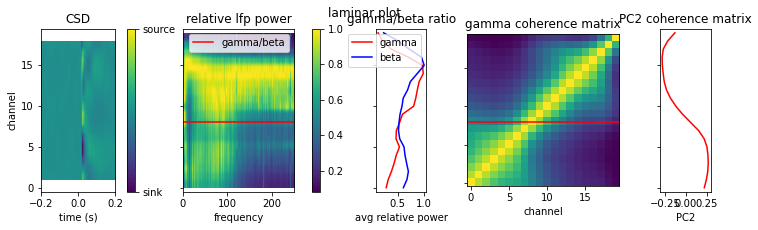

In [14]:
# what happens if you adjust some parameters?  NOTE: beta_range and gamma_range only apply to relative LFP power
# guess = True to plot line guessing top of L4

laminar_plot('laminar plot', csd, relative_power, gamma_cohmat, freqs, fs=fs, 
             beta_range=[10, 30], gamma_range=[80, 250], guess = True)